# 1. Imports

In [1]:
# our functions
import functions as f

# readers

import gzip
import json

import codecs

import numpy as np

import random

# plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import accuracy_score

# NN
## early stopping
import h5py
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# time
from datetime import datetime

# preprocessing
import re
from keras.preprocessing.text import Tokenizer
from collections import defaultdict

# spelling correction
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MUSIC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MUSIC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"

# sent dict
sent_dict = {"positive": 1, "negative": 0}

# 2. Read in the files

In [4]:
train = f.readJson(PATH["music_reviews_train"])
dev = f.readJson(PATH["music_reviews_dev"])
test = f.readJson(PATH["music_reviews_test"])
length_of_sentencies_counter = []

Number of data:  100000
Number of data:  10000
Number of data:  10000


In [5]:
train[0]

{'verified': True,
 'reviewTime': '09 11, 2013',
 'reviewerID': 'AC2PL52NKPL29',
 'asin': '0001388703',
 'style': {'Format:': ' Audio CD'},
 'reviewText': 'So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!',
 'summary': 'Gotta listen to this!',
 'unixReviewTime': 1378857600,
 'sentiment': 'positive',
 'id': 0}

## Corpus Decreasing

## 1 BASIC PREPROCESSING

In [6]:
# we need to delete punctuations and some stop words
import string

def remove_stop_words(text):
    my_stop_words = ['$',"'","``","''","'s"]
    whitespace = [' ', '\t', '\n', '\r', '\x0b', '\x0c']
    punct = ['"','#','$','%', '&', "'",'(', ')', '*', '+', ',', '-', '/', ':', ';', '<', '=', '>', '@', '[', '\\',
             ']', '^', '_', '`', '{', '|', '}', '~'] # ? ! . are deleted
    
    stop_words_be = ['heee','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', '\n', 'the', '\x1bthis']

    stop_words = set(list(my_stop_words) + list(string.digits) + punct + stop_words_be)
    clean_text = []
    length_of_sentencies_counter = []
    
    for sent in text:
        # add whitespaces between punctuations, etc to be able to remove them
        sent = re.sub('(?<! )(?=[.,!?()~${}"|#&%*@\'^+-/_0123456789:>`<;=\[\]])|(?<=[.,!?()~${}"|#&%*@\'^+-/_0123456789:>`<;=\[\]])(?! )', r' ', sent)
        d_sent = []
        for c in sent.split():
            if c in stop_words:
                None
            else:
                d_sent.append(c)
        clean_text.append(list(d_sent))
        length_of_sentencies_counter.append(len(d_sent))
        #print(d_sent)
    return clean_text,length_of_sentencies_counter #length_of_sentencies_counter

## 2. Check for words which are non-english ones

In [7]:
# pretokenizing for basic corpus
pre_tokenizer = Tokenizer( #keras
    num_words=None, # maximum number of words - most common ones
    filters=None, #punctiations, etc
    lower=True,
    split=' ',
    char_level=False, #its not working, anyway
    oov_token=False,
    document_count=0,
)

In [8]:
def unknown_words_to_words(dictionary):
    unk_words_dict = defaultdict(str)
    for word in dictionary:
        if word in ['!','?','.']: # keep the basic puntuations
            unk_words_dict[word] = word
        else:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST,max_edit_distance=2)
        # first finding
            #print(word)
            if len(suggestions) == 0: # if there is no suggestion, or totally fucked word
                None
            else:
                unk_words_dict[word] = suggestions[0].term
    return unk_words_dict

In [9]:
word = "plays"
suggestions = sym_spell.lookup(word, Verbosity.CLOSEST,max_edit_distance=2)
suggestions[0].term

'plays'

In [14]:
import preprocessing as pp

In [16]:
from importlib import reload

In [30]:
reload(pp)

<module 'preprocessing' from 'D:\\ITU-BOOK\\2ndYearProject-NLP\\preprocessing.py'>

In [33]:
dev

[{'vote': '3',
  'verified': True,
  'reviewTime': '12 19, 2012',
  'reviewerID': 'A1KKWETTT5BZ6N',
  'asin': 'B00474S1J2',
  'reviewText': 'My dentist recommended this as a relaxation technique for dental visits. They give me an ipod with headphones, play this on it and it relieves some of the stress of dental treatment, which I dislike intensely.\nIt worked so well that I bought my own copy to try at home. I fall asleep after a couple of minutes and stay asleep. Instead of tossing and turning, I hardly move at all. Highly recommend.',
  'summary': 'Out like a light!',
  'unixReviewTime': 1355875200,
  'sentiment': 'positive',
  'id': 0},
 {'verified': True,
  'reviewTime': '01 19, 2013',
  'reviewerID': 'A15AUN8GDDFVYN',
  'asin': 'B00474QKWC',
  'style': {'Format:': ' MP3 Music'},
  'reviewText': 'I am personally acquainted with a member of this group and I love his music, but unfortunately, despite his efforts and talent which are not well exhibited herein, are for naught.  The lyr

In [38]:
train_sent[0]

'So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!'

In [39]:
example = ["I'm love it"]

In [41]:
train_set_clean, l = pp.basic_preprocess(example)
train_set_clean

[['I', 'm', 'love', 'it']]

In [25]:
train_set_clean, l = pp.basic_preprocess(train_sent)

In [36]:
text = pp.tokenizer_test(dev_sent,tokenizer)

In [ ]:
tokenizer, text = pp.tokenizer_train(train_set_clean)

In [27]:
train_set_clean

[['So',
  'creative',
  '!',
  'Love',
  'his',
  'music',
  'words',
  'message',
  '!',
  'Some',
  'of',
  'my',
  'favorite',
  'songs',
  'on',
  'this',
  'CD',
  '.',
  'I',
  'should',
  'have',
  'bought',
  'it',
  'years',
  'ago',
  '!'],
 ['This',
  'tape',
  'can',
  'hardly',
  'be',
  'understood',
  'and',
  'it',
  'was',
  'listed',
  'for',
  'sale',
  'as',
  'very',
  'good',
  '.',
  'It',
  's',
  'VERY',
  'BAD',
  '.'],
 ['Buy',
  'CD',
  '.',
  'Do',
  'not',
  'buy',
  'MP',
  'album',
  '.',
  'Download',
  'is',
  'no',
  'longer',
  'available',
  '.',
  'But',
  'you',
  'don',
  't',
  'find',
  'that',
  'out',
  'until',
  'after',
  'you',
  'have',
  'purchased',
  'it',
  '.'],
 ['I',
  'love',
  'Dallas',
  'Holms',
  'music',
  'and',
  'voice',
  '!',
  'Thank',
  'You',
  '!',
  'I',
  'will',
  'be',
  'attending',
  'all',
  'his',
  'concerts',
  'in',
  'heaven',
  'forever',
  '!'],
 ['Great', 'memories', 'of', 'my', 'early', 'years', 'in'

In [24]:
pp.remove_stop_words(train_set_clean)

([['So',
   'creative',
   '!',
   'Love',
   'music',
   'words',
   'message',
   '!',
   'Some',
   'favorite',
   'songs',
   'CD',
   '.',
   'I',
   'bought',
   'years',
   'ago',
   '!'],
  ['This',
   'tape',
   'hardly',
   'understood',
   'listed',
   'sale',
   'good',
   '.',
   'It',
   'VERY',
   'BAD',
   '.'],
  ['Buy',
   'CD',
   '.',
   'Do',
   'buy',
   'MP',
   'album',
   '.',
   'Download',
   'longer',
   'available',
   '.',
   'But',
   'find',
   'purchased',
   '.'],
  ['I',
   'love',
   'Dallas',
   'Holms',
   'music',
   'voice',
   '!',
   'Thank',
   'You',
   '!',
   'I',
   'attending',
   'concerts',
   'heaven',
   'forever',
   '!'],
  ['Great', 'memories', 'early', 'years', 'Christ'],
  ['I',
   'listening',
   'album',
   'set',
   'ENTIRE',
   'life',
   'years',
   '!',
   'I',
   'remember',
   'hearing',
   'CD',
   'repeat',
   'every',
   'night',
   'toddler',
   'brought',
   'comfort',
   'sleep',
   'I',
   'always',
   'music',
   

# CREATE A TOKENIZER WITH CORPUS LIMITATION BASED ON THE TRAIN SET

In [10]:
# read the train data
data = train
train_sent = []
train_sentiment = []
train_idx = []
missing_indexies = []
y_train = []
length_of_sentencies_counter = []
for i in range(len(data)):
    try:
        train_sent.append(data[i]["reviewText"])
        train_sentiment.append(data[i]["sentiment"])
        train_idx.append(i)
        y_train.append(sent_dict[data[i]["sentiment"]])
        #length_of_sentencies_counter.append(len(data[i]["reviewText"].split()))
    except KeyError:
        missing_indexies.append(i)
        continue
#print(missing_indexies)


############### CREATE A TOKENIZER
train_set_clean, l = remove_stop_words(train_sent)
pre_tokenizer.fit_on_texts(train_set_clean)
print("Different words", max(pre_tokenizer.index_docs))


# Get a list of words by count
basic_dict = {k: v for k, v in sorted(pre_tokenizer.word_counts.items(), key=lambda item: item[1])}
# convert into default dict to avoid error of missing words
basic_dict = defaultdict(int, basic_dict)
d = unknown_words_to_words(basic_dict)
# set of meaningfull words
s = set(d.values())
print("count of meaningful words", len(s))
spelling_dict = unknown_words_to_words(basic_dict)

Different words 68527
count of meaningful words 39275


length of longest sentence:  26544
length of shortest sentence:  1
average number of words in the sentence
257.3718207832229


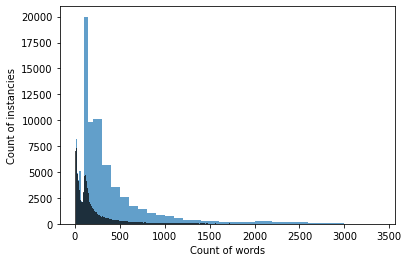

###################

##### SHOW NUMBER OF SHORTEST SENTENCES ONLY #####
length of longest sentence:  26544
length of shortest sentence:  1
average number of words in the sentence
257.3718207832229


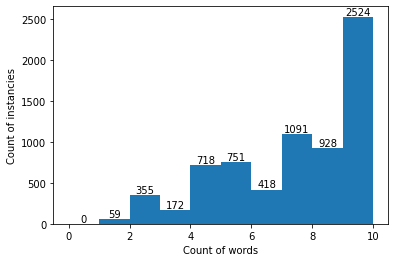

###################

length of longest sentence:  3239
length of shortest sentence:  0
average number of words in the sentence
32.08572629219778


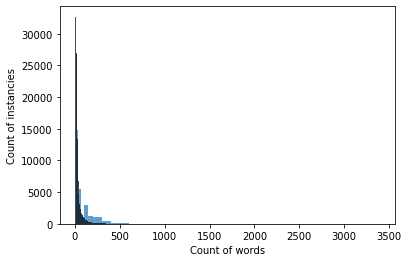

###################

##### SHOW NUMBER OF SHORTEST SENTENCES ONLY #####
length of longest sentence:  3239
length of shortest sentence:  0
average number of words in the sentence
32.08572629219778


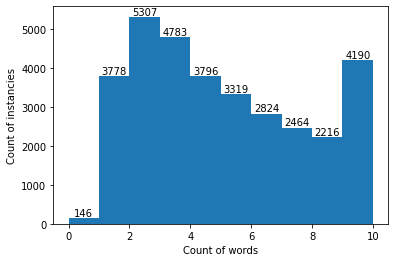

###################



In [10]:
f.simple_stat(train_sent)
f.simple_stat(train_sent, minbins=True)
f.simple_stat(train_set_clean)
f.simple_stat(train_set_clean, minbins=True)

In [11]:
def grammar_corrector(dictionary, text):
    cleaned_text = []
    for line in text:
        temp_line = []
        for word in line:
            temp_line.append(dictionary[word.lower()])
        cleaned_text.append(temp_line)
    return cleaned_text

In [103]:
def grammar_corrector_t(text):
    cleaned_text = []
    for line in text:
        temp_line = []
        # FEED WITH LIST OF LIST OR SIMPLE SENTENCE
        if type(line) == str:
            for word in line.split():
                suggestions = sym_spell.lookup(word, Verbosity.CLOSEST,max_edit_distance=2)
                # if there is no suggestion append "UNK" token
                if len(suggestions) == 0:
                    temp_line.append("UNK")
                else:
                    temp_line.append(suggestions[0].term)
        else:
            for word in line:
                suggestions = sym_spell.lookup(word, Verbosity.CLOSEST,max_edit_distance=2)
                # if there is no suggestion append "UNK" token
                if len(suggestions) == 0:
                    temp_line.append("UNK")
                else:
                    temp_line.append(suggestions[0].term)
        cleaned_text.append(temp_line)
    return cleaned_text

In [110]:
example = ["I'm love it baaaaaart", "You fucking shit"]
grammar_corrector_t(example)

[["i'm", 'love', 'it', 'UNK'], ['you', 'fucking', 'shit']]

In [111]:
example = [["I'm", "love", "it", "baaaaaart"], ["You", "fucking","shit"]]
grammar_corrector_t(example)

[["i'm", 'love', 'it', 'UNK'], ['you', 'fucking', 'shit']]

In [109]:
grammar_corrector_t(example)

[["i'm", 'love', 'it', 'UNK'], ['you', 'fucking', 'shit']]

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(spelling_dict.values())

In [34]:
# read the train data
data = train
train_sent = []
train_sentiment = []
train_idx = []
missing_indexies = []
y_train = []
length_of_sentencies_counter = []
for i in range(len(data)):
    try:
        train_sent.append(data[i]["reviewText"])
        train_sentiment.append(data[i]["sentiment"])
        train_idx.append(i)
        y_train.append(sent_dict[data[i]["sentiment"]])
        #length_of_sentencies_counter.append(len(data[i]["reviewText"].split()))
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

########################## remove stop words delet missing shit 
##### ------------- remove stop words


train_set_clean, l = remove_stop_words(train_sent)
pre_tokenizer.fit_on_texts(train_set_clean)
print("Different words", max(pre_tokenizer.index_docs))
d = unknown_words_to_words(basic_dict)
# set of meaningfull words
s = set(d.values())
print("count of meaningful words", len(s))
# Get a list of words by count
basic_dict = {k: v for k, v in sorted(pre_tokenizer.word_counts.items(), key=lambda item: item[1])}
# convert into default dict to avoid error of missing words
basic_dict = defaultdict(int, basic_dict)
spelling_dict = unknown_words_to_words(basic_dict)


[4603, 4838, 16019, 18229, 19785, 23315, 28397, 28834, 33359, 43138, 43539, 43690, 44008, 44477, 44972, 48811, 49317, 50106, 51717, 52286, 55555, 56171, 57223, 58328, 58799, 58866, 59525, 59739, 61046, 61914, 61916, 62831, 63208, 72268, 78944, 79067, 80093, 80637, 80658, 81640, 81900, 82510, 83138, 83145, 83615, 84761, 87112, 88895, 88984, 89132, 91949, 94301, 94727, 99641]
Different words 68527
count of meaningful words 39275


length of longest sentence:  26544
length of shortest sentence:  1
average number of words in the sentence
257.3718207832229


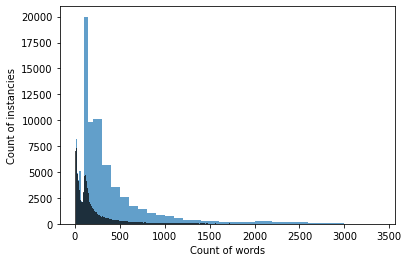

###################

length of longest sentence:  3239
length of shortest sentence:  0
average number of words in the sentence
32.08572629219778


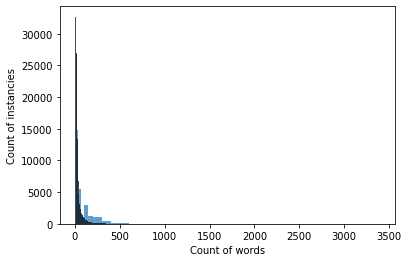

###################



In [14]:
f.simple_stat(train_sent)
f.simple_stat(train_set_clean)

In [35]:
data = dev
print(len(dev))
dev_sent = []
dev_sentiment = []
dev_idx = []
missing_indexies = []
dev_y_train = []
for i in range(len(data)):
    try:
        dev_sent.append(data[i]["reviewText"])
        dev_sentiment.append(data[i]["sentiment"])
        dev_idx.append(i)
        dev_y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

# remove stop words
dev_sent, l = remove_stop_words(dev_sent)

########################## remove stop words delet missing shit 
##### ------------- remove stop words

print("##### ")
empties = []
for i in range(len(dev_sent)):
    if len(dev_sent[i]) == 0:
        empties.append(i)
c = 0
for i in empties:
    #print(train_sent[i-c])
    del dev_sent[i-c]
    del dev_sentiment[i-c]
    del dev_y_train[i-c]
    c += 1
    #print(c)
print(len(dev_sent))
print(len(dev_sentiment))
print(len(dev_y_train))

10000
[2900, 4294, 5135, 8540]
##### 
9984
9984
9984


In [16]:
data = test
test_sent = []
test_sentiment = []
test_idx = []
test_missing_indexies = []
#print(test)
for i in range(len(data)):
    try:
        test_sent.append(data[i]["reviewText"])
        test_sentiment.append(data[i]["sentiment"])
        #print(data[i]["sentiment"])
        test_idx.append(i)
        #y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        test_missing_indexies.append(i)
        continue
print("index of reviews which are empty: ",test_missing_indexies)

# remove stop words
test_sent,l = remove_stop_words(test_sent)

index of reviews which are empty:  [90, 117, 439, 2138, 4112, 5364, 8210]


## New encoder

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(spelling_dict.values()) #words from the grammar correction to idx
#print("The document count",t.document_count)

In [18]:
Train = tokenizer.texts_to_sequences(grammar_corrector(spelling_dict,train_set_clean))
Dev = tokenizer.texts_to_sequences(grammar_corrector(spelling_dict,dev_sent))
Test = tokenizer.texts_to_sequences(grammar_corrector(spelling_dict,test_sent))

##### SHOW NUMBER OF SHORTEST SENTENCES ONLY #####
length of longest sentence:  3239
length of shortest sentence:  0
average number of words in the sentence
32.08572629219778


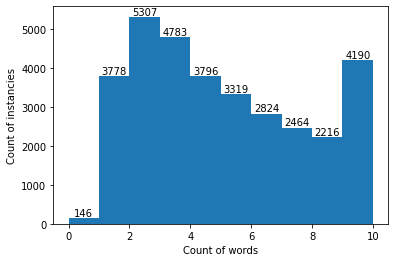

###################

short sentences
['great']
['gift']
['wonderful', '!']
['awesome']
['love']
['all', 'good']
['beautiful', '.']
['great']
['great']
['love', 'music']
['loved', '.']
['like', 'music']
['good']
['excellent', 'cd']
['testing', 'reviews']
['good']
['of']
['wonderful']
['awesome', 'album']
['great', 'album']
['metallica', 'rocks']
['awesome']
['a']
['great', 'cd']
['unexpected']
['love']
['pure', 'garbage']
['saw', 'improvement']
['great']
['wrong', 'format']
['thumbs', '!']
['love', 'album']
['great']
['thanks']
['best', 'album']
['love', '.']
['good']
['great', 'tune']
['good']
['i', 'like']
['love', 'music']
['awesome']
['awesome']
['love']
['fun', 'song']
['original', 'song']
['cute', 'song']
['just', 'beautiful']
['awesome', '!']
['beautiful']
['awesome']
['excellent', 'assistance']
['thanks']
['like']
['great']
['rocking']
['star']
['grate']
['listening', 'relaxing']
['great']
['did', 'purchase']
['excellent']
['classic']
['never', 'ordered']
['satisfied']
['awesome

['great', '.']
['favourite', 'song']
['inspirational']
['very', 'interesting']
['like', 'much']
['one', 'fans']
['i', 'like']
['awesome']
['love', '.']
['worldly']
['expected']
['love', 'song']
['great', 'song']
['wonderful', 'song']
['thank', 'you']
['great']
['one', 'fans']
['love', 'song']
['satisfied']
['love', 'song']
['good']
['dope', 'album']
['love']
['!']
['none']
['boring']
['classic']
['of']
['awesome']
['love']
['classic', '.']
['love']
['extremely', 'satisfied']
['sound', 'perfect']
['perfect']
['good', 'song']
['great', 'song']
['excellent']
['love']
['love']
['monroe', '!']
['love']
['playlist']
['expected']
['great', 'song']
['lug', 'song']
['good', 'music']
['as', 'expected']
['good']
['love']
['awesome', 'song']
['great', 'music']
['good']
['classic', '!']
['love', 'song']
['beautiful']
['soaring', '!']
['it', 'great']
['excellent']
['best']
['awesome']
['love', '.']
['excellent']
['love']
['nice']
['great']
['it', 'nice']
['perfect']
['love']
['skips', '.']
['loved',

['great', 'album']
['classic', 'fun']
['love']
['liked']
['great', '!']
['love']
['great', 'cd']
['good', 'cd']
['love', 'music']
['great', 'music']
['soothing', '.']
['great', '!']
['crap']
['like', '.']
['good']
['its', 'cool']
['love', 'song']
['nice']
['horribly', 'warped']
['love']
['meh']
['not']
['of']
['great', '!']
['bad', 'download']
['gifts', 'loves']
['top', 'gun']
['classic', 'tune']
['great']
['great', 'song']
['love', '.']
['great', 'music']
['great', 'songs']
['great', 'song']
['thank']
['good', 'soundtrack']
['great', 'album']
['of']
['thanks']
['love']
['love', 'song']
['did', 'like']
['amazing', 'meditation']
['happy']
['never']
['excellent']
['nice']
['great']
['great', 'song']
['deleted']
['none']
['']
['gift']
['walker']
['i', 'like']
['excellent']
['great', '!']
['manufactured', 'voice']
['was', 'impressed']
['wonderful']
['nice', 'music']
['thank', '!']
['did', 'purchase']
['strong', 'voice']
['love', 'adele']
['awesome', '!']
['great']
['great', '!']
['love']
[

['a', 'favourite']
['faulty']
['willie', 'finest']
['willy', 'best']
['yes', 'yes']
['beautiful', 'worship']
['love', 'song']
['stupid', '.']
['of']
['magic']
['what', 'say']
['great', 'song']
['good']
['great']
['its', 'of']
['can', 'access']
['great']
['love']
['oldie', 'goodie']
['love', 'elvis']
['one', 'song']
['best']
['love', 'katy']
['nice']
['roar']
['love', 'katy']
[]
['of', '.']
['crap', 'idiots']
['it', 'sucks']
['love', '!']
['i', 'expected']
['happy']
['love']
['good']
['great', '.']
['best', '!']
['love']
['great']
['daughter', 'loves']
['perfect']
['great', 'music']
['of']
['awesome']
['it', 'of']
['great', 'song']
['good', 'download']
['awesome']
['of']
['i', 'expected']
['good', 'song']
['great', 'song']
['great', 'cd']
['thanks']
['not', 'great']
['of']
['great', 'hendrix']
['love', 'song']
[]
['a']
['love']
['great']
['not', 'liking']
['nice', 'song']
['love', '!']
['loved']
['good']
['good', 'music']
['great', 'tune']
['love', 'it']
['great', 'song']
['good']
['not

['really', 'good']
['wonderful', '.']
['great', 'music']
['pretty', 'suck']
['best', 'cd']
['great', 'cd']
['excellent']
['like']
['awesome']
['love']
['song']
['like', 'song']
['i', 'love']
['good', 'cd']
['awesome']
['a']
['good', 'song']
['kiddo', 'loves']
['awesome', 'song']
['much', 'money']
['amazing']
['excellent']
['garbage']
['love']
['marvellous']
['good', 'beat']
['love', '.']
['awesome']
['really', 'awesome']
['love']
['conceited']
['songs', 'good']
['too', 'expensive']
['skips']
['love']
['marina', 'slay']
['outstanding']
['love', 'song']
['excellent']
['awesome', '.']
['kind', 'blah']
['love', 'song']
['addictive']
['queen', '!']
['great', 'song']
['dope', '.']
['overrated']
['skipped', 'box']
['love', 'song']
['love', 'vinyl']
['liked', 'song']
['classic']
['historic', 'album']
['great', 'songs']
['good', 'acetic']
['expected']
['awesome', 'song']
['love', '!']
['love', 'album']
['love']
['great', 'song']
['volume', 'low']
['awesome']
['a']
['trash', '.']
['nah']
['amazi

['love', 'song']
['great', 'song']
['awesome', 'song']
['great', 'album']
['awesome', '!']
['excellent', 'always']
['wonderful', '!']
['good']
['lovely', '!']
['excellent']
['excellent']
['love', '!']
['still', '.']
['love']
['cool']
['thanks']
['nice', '.']
['classic', 'cornell']
['excellent', '!']
['great', 'album']
[]
['thank']
['great', 'voice']
['fax']
['masterpiece', '.']
['good']
['wow']
['overrated', '.']
['beautiful', 'song']
['love', 'song']
['yes']
['liked', 'song']
['awesome', 'song']
['awesome']
['great']
['decent', 'cd']
['all', 'scratched']
['it', 'great']
['off', 'chain']
['amazing', '!']
['very', 'nice']
['totally', 'fabulous']
['amazing', 'song']
['terrible', '.']
['great', 'song']
['good', 'collection']
['love']
['awesome', 'tune']
['awesome']
['awesome', 'music']
['great', 'song']
['sexy']
['classic', '!']
['love', 'song']
['problems']
['love']
['loved', 'cd']
['love', 'song']
['excellent']
['love', '!']
['love', '.']
['disappointed']
['order']
['disappointing']
['g

['love', 'to']
['good']
['soothing']
['of', 'interesting']
['blah']
['like']
['outstanding', 'sound']
['peaceful', 'relaxing']
['excellent', 'regards']
['very', 'good']
['i', 'like']
['excellent', 'tune']
['awesome']
['good']
['lovely']
['great', '!']
['did', 'order']
['like']
['']
['never', 'ordered']
['great']
['great', 'wedding']
['did', 'care']
['amazing', 'sound']
['love', '!']
['great', 'song']
['beautiful', '!']
['love', '!']
['it', 'sucks']
['great', 'music']
['thanks', '!']
['comments']
['i', 'love']
['love', 'song']
['love', '!']
['love']
['viacom', 'rocks']
['love', 'song']
['wonderful']
['great', 'always']
['excellent', 'album']
['great', 'vinyl']
['awesome', '!']
['']
['gift']
['great', 'album']
['bad']
['awesome']
['skip']
[]
[]
['great', 'time']
['great', 'song']
['not', 'original']
['awesome']
['great']
['i', 'expected']
['bad']
['great', 'tune']
['great', 'song']
['great', 'song']
['excellent']
['great']
['love']
[]
['like', 'song']
['hypnotic']
['terrific']
['good']
[

['exactly', 'described']
['love', 'song']
['great', 'song']
['of']
['great']
['great', 'deal']
['great', 'song']
['like', 'song']
['thanks']
['classic']
['great']
['one', 'favourites']
['nice']
['failed', 'download']
['great', 'product']
['great', 'song']
['love', '!']
['alana']
['love']
['love']
['classic']
['classic', '!']
['love', 'a']
['great', '.']
['meh']
['great']
['fantastic']
['love', 'song']
['one', 'favourites']
['love']
['great', 'song']
['love', 'song']
['good', 'song']
['oddly', 'goody']
['great']
['sounds', 'great']
['classic']
['love', '.']
['love', '!']
['good', '!']
['love']
['good', 'tune']
['excellent', '!']
['he']
['love', 'music']
['great', 'music']
['good']
['recommend']
['of']
['type', 'music']
['great', 'band']
['love']
['awesome']
['good', 'good']
['easy', 'use']
['love', '!']
['love']
['great', '!']
['wonderful', '.']
['love', 'song']
['thanks']
['fun', 'song']
['good', 'music']
['favourites', '!']
['great', 'tune']
['love']
['good']
['great']
['great', '!']


['crazy', 'song']
['wonderful', 'music']
['great', 'music']
['of']
['did', 'nothing']
['great']
['love', 'albums']
['beautiful', 'music']
['descent', 'like']
['great', 'song']
['good']
['they', 'really']
['outstanding']
['nice', 'song']
['loved']
['good', 'music']
['phenomenal', '!']
['perfect']
['outstanding', '!']
['good', 'music']
['great', 'tune']
['junk']
['sucks']
['nice']
['loved']
['great']
['geezer', 'classic']
['love', 'music']
['love']
['problems']
['love']
['loved', '!']
['great', 'song']
['great']
['great', 'song']
['good', 'song']
['good', 'song']
['great', 'classic']
['perfect']
['good', 'song']
['loved', 'song']
['great', '!']
['inspiring']
['great']
[]
['hated', 'song']
['very', 'nice']
['awesome']
['love', '.']
['satisfied']
[]
['classic']
['listenable']
['good', '!']
[]
['good', 'music']
['love']
['good', 'music']
['great']
['no', 'good']
['good', 'album']
['good', 'song']
['really', 'good']
['']
['love', 'song']
['awesome']
['love']
['great', 'song']
['great', '!']


In [19]:
# some stat
d = grammar_corrector(spelling_dict,train_set_clean)
f.simple_stat(d, minbins=True)
print("short sentences")
f.print_short_sentence(d, length=2)

length of longest sentence:  2843
length of shortest sentence:  0
average number of words in the sentence
27.78763532307446


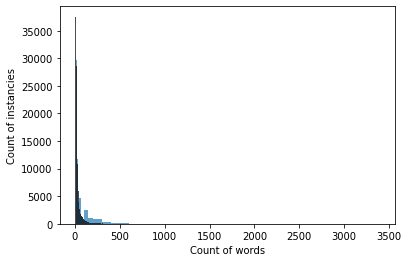

###################

##### SHOW NUMBER OF SHORTEST SENTENCES ONLY #####
length of longest sentence:  2843
length of shortest sentence:  0
average number of words in the sentence
27.78763532307446


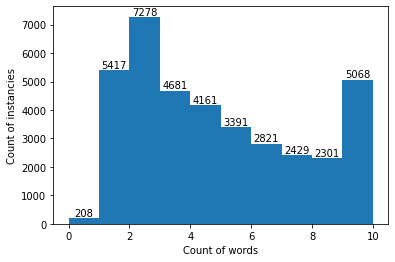

###################



In [20]:
f.simple_stat(Train)
f.simple_stat(Train, minbins=True)
#f.simple_stat(Train)
#f.simple_stat(Dev)
#f.simple_stat(Test)

In [21]:
def sequence_pad(sequence, padding='pre', maxlen=50):
    res = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=maxlen,
        dtype='int32',
        padding=padding,
        truncating='pre',
        value=0.0)
    return res

## Padding the dataset, POST padding works better a little bit

In [23]:
padding = "post"
maxlen = 50 # how many words from the review
X_train_p = sequence_pad(Train, padding=padding, maxlen=maxlen)
X_dev_p = sequence_pad(Dev, padding=padding, maxlen=maxlen)
X_test_p = sequence_pad(Test, padding=padding, maxlen=maxlen)
len(X_train_p)

99946

In [24]:
X_train_m = np.array(X_train_p)
y_train_m = np.array(y_train)
print(len(y_train_m))
print(len(X_train_m))
X_valid_m = np.array(X_dev_p)
y_valid_m = np.array(dev_y_train)
print(len(X_valid_m))
print(len(y_valid_m))
X_test_m = np.array(X_test_p)
#y_test_m = np.array(y_test)
#print(len(X_test_m))
#print(len(y_test_m))

# sampling some random data for tran and DEV
random.seed(40)
bias = 10000

ran = random.randint(0, len(X_train_m)-bias)
ran_val = random.randint(0, len(X_valid_m)-(bias/10))
s_tr = ran
e = ran+bias
s_test = ran_val
e_test = ran_val+(bias/10)

X_train_m = X_train_m[s_tr:e]
y_train_m = y_train_m[s_tr:e]
#X_valid_m = X_valid_m[s_test:int(e_test)]
#y_valid_m = y_valid_m[s_test:int(e_test)]
#X_valid_m = X_valid_m[s:e]
#y_valid_m = y_valid_m[s:e]
print(len(y_train_m))
print(len(X_train_m))

99946
99946
9984
9984
10000
10000


# Early stopping Final

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           7854600   
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 7,975,101
Trainable params: 7,975,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
200/200 [==============================] - 39s 179ms/step - loss: 0.7009 - accuracy: 0.5768 - val_loss: 0.4744 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8717
Epoch 2: ReduceLROnPlateau reducing learning rate t

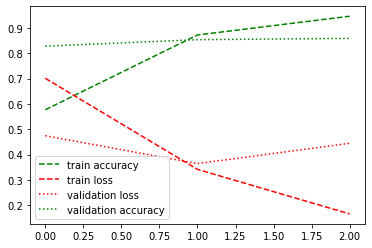

In [25]:
vocabulary_size = len(tokenizer.word_counts)

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# get time for saving the model

dateTimeObj = datetime.now()
save_time = str(dateTimeObj.year)+'-'+str(dateTimeObj.month)+'-'+str(dateTimeObj.day)+'-'+str(dateTimeObj.hour)+'-'+str(dateTimeObj.minute)+'-'+str(dateTimeObj.second)

# define the model

embedding_size=64
embedding_size=200 # bigger = slower train
model=Sequential()
model.add(Embedding(vocabulary_size+1, embedding_size, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='tanh')) # shape of the labels, if its 2, than the y_ labels has a x* 2 shape 

model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

# early stopping

from keras.callbacks import ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='min')
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=0, mode='min')
mcp_save = ModelCheckpoint('model/'+save_time+'-model.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, verbose=1, mode='min') 
############x #factor for learning rate
# patience: 10% of number of epochs. Anyway, it is just for stopping the validation, since we have model checkpoint its doesnt matter
batch_size = 50 # lower = slower train, higher = faster train
num_epochs = 10

#X_valid, y_valid = X_train_k[batch_size:], y_train[batch_size:]
history = model.fit(X_train_m, y_train_m, validation_data=(X_valid_m, y_valid_m), 
                    batch_size=batch_size, 
                    epochs=num_epochs,
                   callbacks=[earlyStopping, mcp_save, reduce_lr_loss])  # for regularization)
#history = model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_trainn, y_trainn, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
plt.plot(history.history["accuracy"], 'g--', label='train accuracy')
plt.plot(history.history["loss"], 'r--', label='train loss')
plt.plot(history.history["val_loss"], 'r:', label='validation loss')
plt.plot(history.history["val_accuracy"], 'g:', label='validation accuracy')
plt.legend()
plt.show()
######### ------------------------- ################### save the model
#model.save('model/'+save_time)

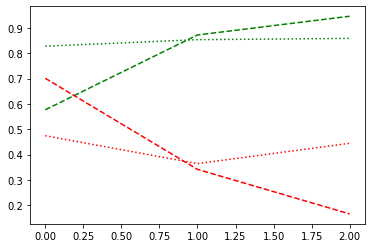

In [26]:
plt.plot(history.history["accuracy"], 'g--', label='train accuracy')
plt.plot(history.history["loss"], 'r--', label='train loss')
plt.plot(history.history["val_loss"], 'r:', label='validation loss')
plt.plot(history.history["val_accuracy"], 'g:', label='validation accuracy')

In [ ]:
model.save('model/'+save_time)

## Result

In [ ]:
#model.save('model/'+save_time)
model = keras.models.load_model('model/'+save_time+'-model.mdl_wts.hdf5')
result = np.round(model.predict(X_valid_m))
accuracy_score(y_valid_m, result)

## Sentiment results, Sampling some guess

In [ ]:
prediction = np.round(model.predict(X_test_p))

In [ ]:
acc = 0
acc_count = 0
res_final = []
for r in prediction:
    acc_count+=1
    if r==0:
        res_final.append("negative")
    if r==1:
        res_final.append("positive")
        
for i in random.sample(range(0, 9993), 5):
    print("index", i)
    print("####", res_final[i], "---", test_sent[i])

In [ ]:
from collections import defaultdict

json_raw_data = []
jsonfilename = 'dataset/classification/tt.gz'
counter = 0
list_of_skip_indexies = [90, 117, 439, 2138, 4112, 5364, 8210]
res_count = 0
for line in gzip.open('dataset/classification/t_masked.gz'):
    review_data = json.loads(line)
    tempdata = []
    if counter in list_of_skip_indexies: # keep origin
        print("keep original")
        print(counter)
        print(review_data)
        res_count -=1
        for key in review_data:
            #print("keep original")
            tempdata.append({
            key: str(review_data[key])})
    else:
        def_dict = defaultdict(list)
        def_dict = dict()
        for key in review_data:
            #print(key)
            if key == "sentiment":
                def_dict[key] = res_final[res_count]
            else:
                tempdata.append({
                key: str(review_data[key])})
                def_dict[key] = str(review_data[key])
    counter += 1
    res_count +=1
    #print(counter)

    #json_raw_data.append(def_dict)
    json_raw_data.append(def_dict) # ok this is very good, itsa opening with json.load
    
outFile = open('music_reviews_test.json', 'w')
for instance in json_raw_data:
      outFile.write(json.dumps(instance) + '\n')
outFile.close()

In [ ]:
for line in gzip.open('group16.json.gz'):
    review_data = json.loads(line)
    for key in review_data:
        print('"' + key +'": ' + str(review_data[key]))
    break